## Мировые линии центров зарядов:

$$
x_1(t) = \frac{1}{2} a_1 t^2, \quad x_2(t) = d + \frac{1}{2} a_2 t^2
$$

Мировые трубки — это области вокруг этих линий, с фиксированной шириной (в сопутствующей системе).


In [33]:
var("t1_0, t2_0, a_1, a_2, d, l")

assume(x, "real")

t1   = t1_0 + sqrt(2*x/a_1)
t1_l = t1_0 + sqrt(2*(x+l)/a_1)
t1_r = t1_0 + sqrt(2*(x-l)/a_1)

t2   = t2_0 + sqrt(2*(x-d)/a_2)
t2_l = t2_0 + sqrt(2*(x+l-d)/a_2)
t2_r = t2_0 + sqrt(2*(x-l-d)/a_2)

Как найти уравнение перпендикуляра

Найдите угловой коэффициент (наклон) мировой линии. Если угловой коэффициент мировой линии равен $k= (dt/dx) = \frac{1}{\left(a_1 \cdot t_1\right)}$,

In [34]:
show(t1.diff(x).expand())

1/2*sqrt(2)/(a_1*sqrt(x/a_1))

 то угловой коэффициент перпендикулярной прямой равен $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$. 
Используйте формулу уравнения прямой вида $t_1 = -\left(a_1 \cdot t_1\right) x + b$, подставив точку проведения перпендикуляра отрезка и новый угловой коэффициент, чтобы найти b. 

 $t_1 = -\left(a_1 \cdot t_1\right) \frac{1}{2} a_1 t_1^2 + b$
 
 $b = t_1  + \frac{a_1^2}{2}  t_1^3$

In [35]:
def normal_spline_segment(x_left, t_left, m_left, x_right, t_right, m_right):
    # Строит кубический полином N(x) = a0 + a1*x + a2*x^2 + a3*x^3
    # такой что:
    #   N(x_left) = t_left,   N'(x_left) = m_left
    #   N(x_right) = t_right, N'(x_right) = m_right

    var('a0 a1 a2 a3')
    N(x) = a0 + a1*x + a2*x^2 + a3*x^3
    dN(x) = diff(N(x), x)

    eqs = [
        N(x_left) == t_left,
        dN(x_left) == m_left,
        N(x_right) == t_right,
        dN(x_right) == m_right
    ]

    sol = solve(eqs, a0, a1, a2, a3, solution_dict=True)[0]
    return N.subs(sol)

In [36]:
# === Вспомогательная функция: кубический сплайн ===
def cubic_spline_segment(x_left, t_left, m_left, x_right, t_right, m_right):
    var('a0 a1 a2 a3')
    N(x) = a0 + a1*x + a2*x^2 + a3*x^3
    dN(x) = diff(N(x), x)
    eqs = [
        N(x_left) == t_left,
        dN(x_left) == m_left,
        N(x_right) == t_right,
        dN(x_right) == m_right
    ]
    sol = solve(eqs, a0, a1, a2, a3, solution_dict=True)
    if not sol:
        return lambda x: 0
    return N.subs(sol[0])

In [233]:
def tubes_plot(A1, A2, L, D, T1, T2, T1_start = 0.0, T2_start = 0.0, mode='simple', logging=False):
    """
    mode: 
        'simple'  -> перпендикуляры к центральной линии
        'perp'    -> перпендикуляры от границ к центру
        'exponential'  -> двухсегментный кубический сплайн (перпендикулярный ко всем трём)
    """

    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = A1*T1^2/2
    S2 = A2*T2^2/2

    values = [a_1 == A1, a_2 == A2, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    x_1 = S1
    x_2 = D + S2
    t_1 = T1
    t_2 = T2

    # угловой коэффициент прямой перпендикулярной центральной мировой линии 
    # в точке, соответствующей вычисленной выше перемещению равен
    # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
    m1 = -A1*T1
    m2 = -A2*T2

    # Используйте формулу уравнения прямой вида
    # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
    # подставив точку проведения перпендикуляра отрезка
    # и новый угловой коэффициент, чтобы найти b.
    b1 = t_1 - m1 * x_1
    b2 = t_2 - m2 * x_2

    # уравнения прямой перпендикулярной центральной мировой линии каждого из зарядов
    perp_1 = m1*x + b1
    perp_2 = m2*x + b2

    # x координата точки пересечения перпендикуляра к центральной мировой линии
    # с левой и правой границей мировой трубки
    # для каждого из зарядов

    # === Исправленная функция поиска пересечения ===
    def solve_intersection(curve_expr, line_expr, var_x=x, domain_lower=0, make_square=True):
        curve_num = curve_expr.subs(values)
        line_num = line_expr.subs(values)
        
        if make_square:
            # Уравнение: curve_num == line_num → возводим в квадрат
            eq = (curve_num)^2 == (line_num)^2
            #eq = ((curve_num)^2).expand() == ((line_num)^2).expand()
        else:
            eq = curve_num == line_num
        #print("eq", eq)
            

        sol = solve(eq, var_x, solution_dict=True)
        #print("sol", sol)
        valid_solutions = []

        for s in sol:
            xv = s[var_x]
            xv_num = xv.subs(values)#.n()
            if not xv_num.is_real():
                continue
            xv_val = float(xv_num)
            if xv_val < domain_lower - 1e-6:
                continue

            # Проверка: не появился ли "лишний" корень?
            t_curve = curve_num.subs(var_x == xv_val).n()
            t_line  = line_num.subs(var_x == xv_val).n()
            if abs(t_curve - t_line) < 1e-6 and t_curve >= 0:
                valid_solutions.append(xv_val)

        if not valid_solutions:
            return None
        # Возвращаем ближайшее к центру решение
        center = (x_1 if '1' in str(curve_expr) else x_2)
        return min(valid_solutions, key=lambda xv: abs(xv - center))

    if mode == 'simple':
        # Найдём пересечения перпендикуляров к центру с границами
        x_1_l = solve_intersection(t1_l, perp_1, domain_lower=-L)
        x_1_r = solve_intersection(t1_r, perp_1, domain_lower=L)

        x_2_l = solve_intersection(t2_l, perp_2, domain_lower=D - L)
        x_2_r = solve_intersection(t2_r, perp_2, domain_lower=D + L)

        if logging:
            print("x_1_l", x_1_l)
            print("x_1_r", x_1_r)
            print("x_2_l", x_1_l)
            print("x_2_r", x_1_r)


        x_1_l = solve ((t1_l^2 == perp_1^2).subs(values), [x])[0].rhs()
        x_1_r = solve ((t1_r^2 == perp_1^2).subs(values), [x])[0].rhs()

        x_2_l = solve ((t2_l^2 == perp_2^2).subs(values), [x])[0].rhs()
        x_2_r = solve ((t2_r^2 == perp_2^2).subs(values), [x])[0].rhs()

        if logging:
            print("x_1_l", x_1_l)
            print("x_1_r", x_1_r)
            print("x_2_l", x_1_l)
            print("x_2_r", x_1_r)
        
        # t координата точки пересечения перпендикуляра к центральной мировой линии
        # с левой и правой границей мировой трубки
        # для каждого из зарядов

        # t координаты точек пересечения
        t_1_l = t1_l.subs(x == x_1_l).subs(values)
        t_1_r = t1_r.subs(x == x_1_r).subs(values)

        t_2_l = t2_l.subs(x == x_2_l).subs(values)
        t_2_r = t2_r.subs(x == x_2_r).subs(values)

        # угловой коэффициент прямой перпендикулярной левой и правой границе мировой трубки
        # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
        m1_l = -A1*t_1_l
        m1_r = -A1*t_1_r
        m2_l = -A2*t_2_l
        m2_r = -A2*t_2_r

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку проведения перпендикуляра отрезка
        # и новый угловой коэффициент, чтобы найти b.
        b1_l = t_1_l - m1_l * x_1_l
        b1_r = t_1_r - m1_r * x_1_r

        b2_l = t_2_l - m2_l * x_2_l
        b2_r = t_2_r - m2_r * x_2_r

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l = m1_l*x + b1_l
        perp_1_r = m1_r*x + b1_r
        perp_2_l = m2_l*x + b2_l
        perp_2_r = m2_r*x + b2_r

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с противоположной границей мировой трубки
        # для каждого из зарядов

        x_1_lr = solve ((t1_l^2 == perp_1_r^2).subs(values), [x])[1].rhs()
        x_1_rl = solve ((t1_r^2 == perp_1_l^2).subs(values), [x])[1].rhs()

        x_2_lr = solve ((t2_l^2 == perp_2_r^2).subs(values), [x])[1].rhs()
        x_2_rl = solve ((t2_r^2 == perp_2_l^2).subs(values), [x])[1].rhs()
    elif mode == 'perp':
        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # для каждого из зарядов
        t_1_lc = var("t_1_lc")
        t_1_rc = var("t_1_rc")

        t_2_lc = var("t_2_lc")
        t_2_rc = var("t_2_rc")

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # для каждого из зарядов
        x_1_lc = var("x_1_lc")
        x_1_rc = var("x_1_rc")

        x_2_lc = var("x_2_lc")
        x_2_rc = var("x_2_rc")

        # угловой коэффициент прямой перпендикулярной левой и правой границе мировой трубки
        # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
        # в только что выше обозначенных точках t_1_l_, t_1_r_, t_2_l_, t_2_r_
        m1_lc = -A1*t_1_lc
        m1_rc = -A1*t_1_rc
        m2_lc = -A2*t_2_lc
        m2_rc = -A2*t_2_rc

        if logging:
            print("m1_lc = ", m1_lc)
            print("m1_rc = ", m1_rc)
            print("m2_lc = ", m2_lc)
            print("m2_rc = ", m2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # и новый угловой коэффициент, чтобы найти b.

        b1_lc = var("b1_lc")
        b1_rc = var("b1_rc")

        b2_lc = var("b2_lc")
        b2_rc = var("b2_rc")

        # eqc_b1_lc = b1_lc == t_1 - m1_lc * x_1
        # eqc_b1_rc = b1_rc == t_1 - m1_rc * x_1

        # eqc_b2_lc = b2_lc == t_2 - m2_lc * x_2
        # eqc_b2_rc = b2_rc == t_2 - m2_rc * x_2

        eqc_b1_lc = t_1 == b1_lc + m1_lc * x_1 
        eqc_b1_rc = t_1 == b1_rc + m1_rc * x_1

        eqc_b2_lc = t_2 == b2_lc + m2_lc * x_2
        eqc_b2_rc = t_2 == b2_rc + m2_rc * x_2 

        if logging:
            print("eqc_b1_lc = ", eqc_b1_lc)
            print("eqc_b1_rc = ", eqc_b1_rc)
            print("eqc_b2_lc = ", eqc_b2_lc)
            print("eqc_b2_rc = ", eqc_b2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку проведения перпендикуляра отрезка
        # и новый угловой коэффициент, чтобы найти b.
        eq_b1_lc = b1_lc == t_1_lc - m1_lc * x_1_lc
        eq_b1_rc = b1_rc == t_1_rc - m1_rc * x_1_rc

        eq_b2_lc = b2_lc == t_2_lc - m2_lc * x_2_lc
        eq_b2_rc = b2_rc == t_2_rc - m2_rc * x_2_rc

        if logging:
            print("eq_b1_lc = ", eq_b1_lc)
            print("eq_b1_rc = ", eq_b1_rc)
            print("eq_b2_lc = ", eq_b2_lc)
            print("eq_b2_rc = ", eq_b2_rc)

        # eq_c_b1_lc = t_1_lc - m1_lc * x_1_lc == t_1 - m1_lc * x_1
        # eq_c_b1_rc = t_1_rc - m1_rc * x_1_rc == t_1 - m1_rc * x_1

        # eq_c_b2_lc = t_2_lc - m2_lc * x_2_lc == t_2 - m2_lc * x_2
        # eq_c_b2_rc = t_2_rc - m2_rc * x_2_rc == t_2 - m2_rc * x_2

        eq_c_b1_lc = eqc_b1_lc.solve(b1_lc)[0].rhs() == eq_b1_lc.solve(b1_lc)[0].rhs()
        eq_c_b1_rc = eqc_b1_rc.solve(b1_rc)[0].rhs() == eq_b1_rc.solve(b1_rc)[0].rhs()

        eq_c_b2_lc = eqc_b2_lc.solve(b2_lc)[0].rhs() == eq_b2_lc.solve(b2_lc)[0].rhs()
        eq_c_b2_rc = eqc_b2_rc.solve(b2_rc)[0].rhs() == eq_b2_rc.solve(b2_rc)[0].rhs()

        if logging:
            print("eq_c_b1_lc = ", eq_c_b1_lc)
            print("eq_c_b1_rc = ", eq_c_b1_rc)
            print("eq_c_b2_lc = ", eq_c_b2_lc)
            print("eq_c_b2_rc = ", eq_c_b2_rc)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_lc = m1_lc*x + b1_lc
        perp_1_rc = m1_rc*x + b1_rc
        perp_2_lc = m2_lc*x + b2_lc
        perp_2_rc = m2_rc*x + b2_rc

        if logging:
            print("perp_1_lc = ", perp_1_lc)
            print("perp_1_rc = ", perp_1_rc)
            print("perp_2_lc = ", perp_2_lc)
            print("perp_2_rc = ", perp_2_rc)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с противоположной границей мировой трубки
        # для каждого из зарядов

        eq_x_1_lc = (t1_l^2 == t_1_lc^2).solve(x)[0].subs(x == x_1_lc).subs(values)
        eq_x_1_rc = (t1_r^2 == t_1_rc^2).solve(x)[0].subs(x == x_1_rc).subs(values)
        eq_x_2_lc = (t2_l^2 == t_2_lc^2).solve(x)[0].subs(x == x_2_lc).subs(values)
        eq_x_2_rc = (t2_r^2 == t_2_rc^2).solve(x)[0].subs(x == x_2_rc).subs(values)

        if logging:
            print("eq_x_1_lc = ", eq_x_1_lc)
            print("eq_x_1_rc = ", eq_x_1_rc)
            print("eq_x_2_lc = ", eq_x_2_lc)
            print("eq_x_2_rc = ", eq_x_2_rc)

        eq_t_1_lc = eq_c_b1_lc.subs(eq_x_1_lc)
        eq_t_1_rc = eq_c_b1_rc.subs(eq_x_1_rc)
        eq_t_2_lc = eq_c_b2_lc.subs(eq_x_2_lc)
        eq_t_2_rc = eq_c_b2_rc.subs(eq_x_2_rc)

        if logging:
            print("eq_t_1_lc = ", eq_t_1_lc)
            print("eq_t_1_rc = ", eq_t_1_rc)
            print("eq_t_2_lc = ", eq_t_2_lc)
            print("eq_t_2_rc = ", eq_t_2_rc)

        sol_t_1_lc = solve (eq_t_1_lc, t_1_lc)[2]
        sol_t_1_rc = solve (eq_t_1_rc, t_1_rc)[2]
        sol_t_2_lc = solve (eq_t_2_lc, t_2_lc)[2]
        sol_t_2_rc = solve (eq_t_2_rc, t_2_rc)[2]

        if logging:
            print("sol_t_1_lc = ", sol_t_1_lc)
            print("sol_t_1_rc = ", sol_t_1_rc)
            print("sol_t_2_lc = ", sol_t_2_lc)
            print("sol_t_2_rc = ", sol_t_2_rc)

        sol_x_1_lc = eq_x_1_lc.subs(sol_t_1_lc)
        sol_x_1_rc = eq_x_1_rc.subs(sol_t_1_rc)
        sol_x_2_lc = eq_x_2_lc.subs(sol_t_2_lc)
        sol_x_2_rc = eq_x_2_rc.subs(sol_t_2_rc)

        if logging:
            print("sol_x_1_lc = ", sol_x_1_lc)
            print("sol_x_1_rc = ", sol_x_1_rc)
            print("sol_x_2_lc = ", sol_x_2_lc)
            print("sol_x_2_rc = ", sol_x_2_rc)

        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # для каждого из зарядов
        t_1_l_c = t_1_lc.subs(sol_t_1_lc)
        t_1_r_c = t_1_rc.subs(sol_t_1_rc)

        t_2_l_c = t_2_lc.subs(sol_t_2_lc)
        t_2_r_c = t_2_rc.subs(sol_t_2_rc)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # для каждого из зарядов
        x_1_l_c = x_1_lc.subs(sol_x_1_lc)
        x_1_r_c = x_1_rc.subs(sol_x_1_rc)

        x_2_l_c = x_2_lc.subs(sol_x_2_lc)
        x_2_r_c = x_2_rc.subs(sol_x_2_rc)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l_c = perp_1_lc.subs(eqc_b1_lc.solve(b1_lc)).subs(sol_t_1_lc)
        perp_1_r_c = perp_1_rc.subs(eqc_b1_rc.solve(b1_rc)).subs(sol_t_1_rc)
        perp_2_l_c = perp_2_lc.subs(eqc_b2_lc.solve(b2_lc)).subs(sol_t_2_lc)
        perp_2_r_c = perp_2_rc.subs(eqc_b2_rc.solve(b2_rc)).subs(sol_t_2_rc)

        if logging:
            print("perp_1_l_c = ", perp_1_l_c)
            print("perp_1_r_c = ", perp_1_r_c)
            print("perp_2_l_c = ", perp_2_l_c)
            print("perp_2_r_c = ", perp_2_r_c)

    plt = Graphics()


    if mode == 'simple':
        plt_perp_1   = plot((perp_1, -perp_1),   x, x_1_l, x_1_r, color="red")
        plt_perp_2   = plot((perp_2, -perp_2),   x, x_2_l, x_2_r, color="red")

        plt += plt_perp_1
        plt += plt_perp_2
    #elif mode == 'simple':
        plt_perp_1_l   = plot((perp_1_l, -perp_1_l),   x, x_1_l, x_1_rl, color="green")
        plt_perp_1_r   = plot((perp_1_r, -perp_1_r),   x, x_1_lr, x_1_r, color="blue")
        plt_perp_2_l   = plot((perp_2_l, -perp_2_l),   x, x_2_l, x_2_rl, color="green")
        plt_perp_2_r   = plot((perp_2_r, -perp_2_r),   x, x_2_lr, x_2_r, color="blue")

        plt += plt_perp_1_l
        plt += plt_perp_1_r
        plt += plt_perp_2_l
        plt += plt_perp_2_r
    elif mode == 'perp':
        plt_perp_1_lc   = plot((perp_1_l_c, -perp_1_l_c),   x, x_1_l_c, x_1, color="green")
        plt_perp_1_rc   = plot((perp_1_r_c, -perp_1_r_c),   x, x_1, x_1_r_c, color="blue")
        plt_perp_2_lc   = plot((perp_2_l_c, -perp_2_l_c),   x, x_2_l_c, x_2, color="green")
        plt_perp_2_rc   = plot((perp_2_r_c, -perp_2_r_c),   x, x_2, x_2_r_c, color="blue")

        plt += plt_perp_1_lc
        plt += plt_perp_1_rc
        plt += plt_perp_2_lc
        plt += plt_perp_2_rc

    elif mode == 'exponential':
        # Для первого заряда
        x0 = S1
        t0 = T1_start + T1

        # Экспоненциальная кривая
        t_exp(x) = t0 * exp(-A1 * (x - x0))

        # Левая граница: t_exp(x) = t1_l(x)
        def f_left(x_val):
            try:
                # Проверяем, что подкоренное выражение неотрицательно
                if x_val + L < 0:
                    return float('nan')
                # Вычисляем значение
                val = t_exp(x_val) - t1_l.subs(values).subs(x == x_val)
                val = t_exp(x_val) - (T1_start + sqrt(2*(x_val + L)/A1))
                # Если val комплексное — возвращаем nan
                if val.is_real():
                    return float(val.n())
                else:
                    return float('nan')
            except:
                return float('nan')

        #def f_right(x_val):
        #    #return t_exp(x_val) - t1_r.subs(values).subs(x == x_val)
        #    return (t_exp(x_val) - (T1_start + sqrt(2*(x_val - L)/A1)))
        def f_right(x_val):
            try:
                if x_val - L < 0:
                    return float('nan')
                val = t_exp(x_val) - t1_r.subs(values).subs(x == x_val)
                # val = t_exp(x_val) - (T1_start + sqrt(2*(x_val - L)/A1))
                if val.is_real():
                    return float(val.n())
                else:
                    return float('nan')
            except:
                return float('nan')

        # Области поиска
        x_left_min = max(-L + 1e-6, x0 - 2*L)
        x_left_max = x0

        x_right_min = x0
        x_right_max = x0 + 2*L

        try:
            xL_exp = find_root(f_left, x_left_min, x_left_max)
        except Exception as ex:
            print("Error in find_root for left boundary:", ex)
            xL_exp = x0 - L

        try:
            print(f_right(x_right_min))
            print(f_right(x_right_max))
            xR_exp = find_root(f_right, x_right_min, x_right_max)
        except Exception as ex:
            print("Error in find_root for right boundary:", ex)
            xR_exp = x0 + L

        # Рисуем экспоненту между пересечениями
        plt += plot(t_exp, x, xL_exp, xR_exp, color='orange', thickness=2)
        plt += plot(-t_exp, x, xL_exp, xR_exp, color='orange', thickness=2)

        # Для второго заряда
        x0_2 = D + S2
        t0_2 = T2_start + T2
        t_exp2(x) = t0_2 * exp(-A2 * (x - x0_2))
        
        # Области определения границ
        x_left_domain2 = D - L  # левая граница определена при x <= x_left_domain2
        x_right_domain2 = D + L  # правая граница определена при x >= x_right_domain2
        
        def f_left2(x_val):
            try:
                if x_val + L - D < 0:
                    return float('nan')
                val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val + L - D)/A2))
                if val.is_real():
                    return float(val.n())
                else:
                    return float('nan')
            except:
                return float('nan')

        #def f_left2(x_val):
        #    if x_val > x_left_domain2:
        #        return float('nan')
        #    try:
        #        val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val + L - D)/A2))
        #        return float(val.n()) if val.is_real() else float('nan')
        #    except:
        #        return float('nan')

        #def f_right2(x_val):
        #    try:
        #        if x_val - L - D < 0:
        #            return float('nan')
        #        val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val - L - D)/A2))
        #        if val.is_real():
        #            return float(val.n())
        #        else:
        #            return float('nan')
        #    except:
        #        return float('nan')

        def f_right2(x_val):
            if x_val < x_right_domain2:
                return float('nan')
            try:
                val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val - L - D)/A2))
                return float(val.n()) if val.is_real() else float('nan')
            except:
                return float('nan')
            
        x_left_min2 = max(D - L + 1e-6, x0_2 - 2*L)
        x_left_max2 = x0_2
        x_right_min2 = x0_2-L
        x_right_max2 = x0_2 + 3*L
    
        # Интервалы поиска
        #x_left_min2 = max(D - L - 2*L, x0_2 - 2*L)  # достаточно далеко влево
        #x_left_max2 = min(x_left_domain2 - 1e-6, x0_2)

        x_right_min2 = max(x_right_domain2 + 1e-6, x0_2)
        #x_right_min2 = max(x0_2, D + L + 1e-6)  # = max(1.3725, 1.35 + 0.4) = 1.75
        x_right_max2 = x0_2 + 2*L

        try:
            xL_exp2 = find_root(f_left2, x_left_min2, x_left_max2)
        except Exception as ex:
            print("Error in find_root for left boundary (charge 2):", ex)
            xL_exp2 = x0_2 - L

        try:
            print(f_right2(x_right_min2))
            print(f_right2(x_right_max2))
            xR_exp2 = find_root(f_right2, x_right_min2, x_right_max2)
        except Exception as ex:
            print("Error in find_root for right boundary (charge 2):", ex)
            xR_exp2 = x0_2 + L

        plt += plot(t_exp2, x, xL_exp2, xR_exp2, color='orange', thickness=2)
        plt += plot(-t_exp2, x, xL_exp2, xR_exp2, color='orange', thickness=2)

        # Найдём пересечения перпендикуляров к центру с границами
        #x_1_l = solve_intersection(t1_l-t1_0, t_exp(x)+t1_0, domain_lower=-L)#, make_square=False)
        #x_1_r = solve_intersection(t1_r-t1_0, t_exp(x)+t1_0, domain_lower= L)#, make_square=False)

        #x_2_l = solve_intersection(t2_l-t2_0, t_exp2(x)+t2_0, domain_lower=D - L)#, make_square=False)
        #x_2_r = solve_intersection(t2_r-t2_0, t_exp2(x)+t2_0, domain_lower=D + L)#, make_square=False)

        #print("x_1_l", x_1_l)
        #print("x_1_r", x_1_r)
        #print("x_2_l", x_1_l)
        #print("x_2_r", x_1_r)

        _x_1_l = xL_exp
        _x_1_r = xR_exp
        _x_2_l = xL_exp2
        _x_2_r = xR_exp2
    # пределы отрисовки мировых линий

    if mode == 'perp':
        _x_1_l = x_1_l_c
        _x_1_r = x_1_r_c
        _x_2_l = x_2_l_c
        _x_2_r = x_2_r_c
    if mode == 'simple':
        _x_1_l = x_1_l
        _x_1_r = x_1_r
        _x_2_l = x_2_l
        _x_2_r = x_2_r
        
    # отрисовка мировых трубок

    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1, color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   D + S2, color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt

    plt.show(aspect_ratio=1, axes=False)

In [234]:
# accelerations
A1 = 3
A2 = 2

#half-length of the charges
L = 0.4

# distance between centers of the charges
D = 2*L + 0.05

# time duration of the tube
T1 = 0.50
T2 = 0.15

# time when velocity of charche is zero
T1_0 = 0.4
T2_0 = -0.1
T1_0 = 0
T2_0 = -0

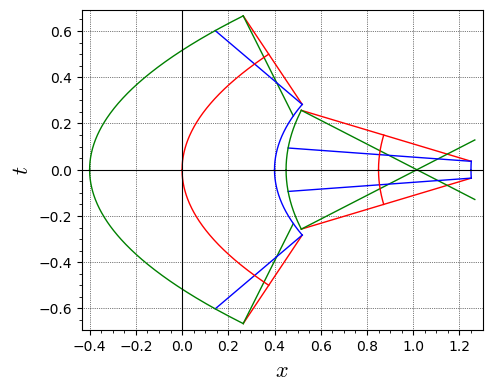

In [235]:
# Пример использования:

# Режим 'simple' — как было
p = tubes_plot(A1, A2, L, D, T1, T2, mode='simple')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

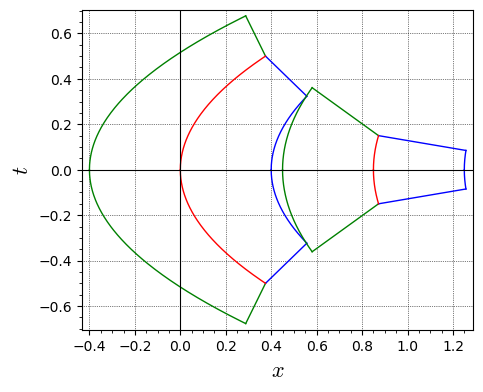

In [236]:
# Пример использования:

# Режим 'perp' — как во втором рисунке
p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

nan
-0.6734363117835546
0.06950145120663394
-0.6197155223008016


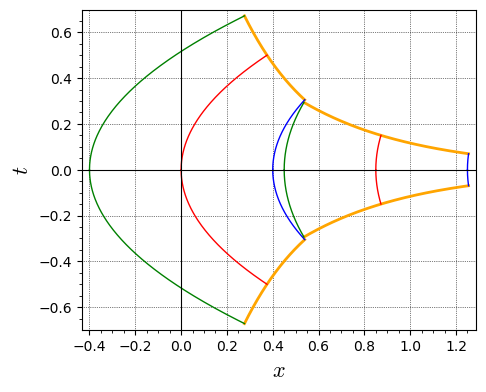

In [237]:
# Пример использования:

p = tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

nan
-0.6734363117835546
0.06950145120663394
-0.6197155223008016


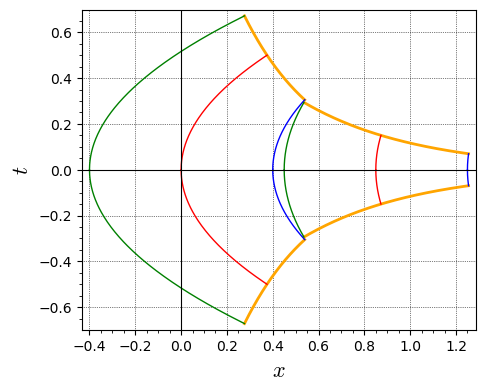

In [238]:

# Пример использования:

# Режим 'simple' — как было
p = tubes_plot(A1, A2, L, D, T1, T2, mode='simple')

# Режим 'perp' — как во втором рисунке
#p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')

p = tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential')


p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

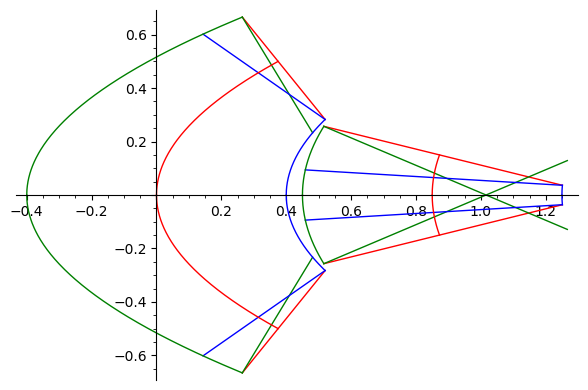

In [239]:
tubes_plot(A1, A2, L, D, T1, T2)

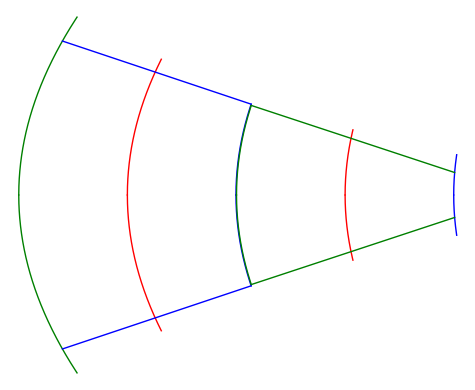

In [68]:
@interact
def _(A1=slider(srange(0,10,.1),default = 2),
      A2=slider(srange(0,10,.1),default = 2),
      T1=slider(srange(.005,1,.005),default = 0.25),
      T2=slider(srange(.005,1,.005),default = 0.16),
      D=slider(srange(.01,10,.01),default = 2*L + 0.02)):
    tubes_plot(A1, A2, L, D=D, T1=T1, T2=T2).show(aspect_ratio=1)

Interactive function <function _ at 0x7f0e3c381d80> with 5 widgets
  A1: SelectionSlider(description='A1', ind…


## 🔷 Шаг 1: Модель и обозначения

Рассмотрим **двумерное сечение** пространства-времени: оси $(t, x)$.  
Два заряда движутся вдоль оси $x$, с ускорениями $a_1$, $a_2$, начальные координаты:  
- Заряд 1: $x = 0$,
- Заряд 2: $x = d$.

Их мировые линии (в нерелятивистском приближении, $v \ll c$):

$$
t_1(\tau) = \tau, \quad x_1(\tau) = \frac{1}{2} a_1 \tau^2
$$
$$
t_2(\tau) = \tau, \quad x_2(\tau) = d + \frac{1}{2} a_2 \tau^2
$$

Мировые трубки — узкие полосы вокруг этих линий.

---

## 🔷 Шаг 2: Нормальные сечения

В каждый момент $\tau$, **нормальное сечение** — это прямая, **ортогональная 4-скорости**.

При $v \ll c$, 4-скорость: $u^\mu \approx (c, v)$,  
ортогональный вектор: $(v, c)$,  
в $(t,x)$-сечении: наклон $\frac{dt}{dx} = \frac{v}{c^2}$.

Но при $v \ll c$, можно считать, что **нормальное сечение почти горизонтально**, и его уравнение:

$$
t = \tau + \frac{1}{2c^2} a_i (x - x_i(\tau)) \quad \text{(с точностью до } 1/c^2\text{)}
$$

👉 Однако, для простоты, в **нулевом приближении** (малые скорости, малые ускорения) будем считать, что **нормальные сечения горизонтальны**:  
- В трубке 1: $t = t_1$,
- В трубке 2: $t = t_2$.

---

## 🔷 Шаг 3: Построение гладкой границы $t = t(x)$

Пусть область интегрирования ограничена:
- Снизу: кривая $t = t_{\text{нижн}}(x)$,
- Сверху: кривая $t = t_{\text{верх}}(x)$.

Рассмотрим **верхнюю границу** — она соединяет два нормальных сечения.

Пусть:
- В области заряда 1 ($x \in [0 - \ell, 0 + \ell]$): $t = t_0$,
- В области заряда 2 ($x \in [d - \ell, d + \ell]$): $t = t_0 + \delta t$,
- В промежутке $x \in [\ell, d - \ell]$: плавный переход.

Но! Чтобы минимизировать "длину" границы (аналог $\int \sqrt{1 + (dt/dx)^2} dx$), нужно сделать $dt/dx$ как можно меньше.

👉 **Оптимальная кривая** — **гладкая, с нулевыми производными на концах**.

Используем **кубический сплайн**:

$$
t(x) = 
\begin{cases}
t_0 & x \in [0 - \ell, \ell] \\
t_0 + A(x - \ell)^3 + B(x - \ell)^2 + C(x - \ell) & x \in [\ell, d - \ell] \\
t_0 + \Delta t & x \in [d - \ell, d + \ell]
\end{cases}
$$

Где $\Delta t = \frac{1}{2c^2} a_2 d \cdot t_0$ — поправка из-за разного ускорения.

Условия гладкости:
- $t(\ell) = t_0$, $t'( \ell) = 0$,
- $t(d - \ell) = t_0 + \Delta t$, $t'(d - \ell) = 0$.

Решая, получаем:

$$
t(x) = t_0 + \Delta t \cdot \left( \frac{x - \ell}{d - 2\ell} \right)^2 \left( 3 - 2 \frac{x - \ell}{d - 2\ell} \right)
\quad \text{для} \quad x \in [\ell, d - \ell]
$$

✅ Это — **гладкая, $C^1$ кривая**, без изломов, минимальной "кривизны".



## 🔷 Шаг 4: Минимизация кривизны — кубический сплайн

Минимизация $\int (f'')^2 dx$ при заданных $f, f'$ на концах даёт **кубический сплайн**.

Решение:

$$
f(x) = t_0 + \frac{a_1}{c^2} x \left(1 - \frac{x}{d}\right)^2 + \frac{a_2}{c^2} (x - d) \left(\frac{x}{d}\right)^2
$$

✅ Проверка:
- $f(0) = t_0$, $f'(0) = \frac{a_1}{c^2}$,
- $f(d) = t_0$, $f'(d) = \frac{a_2}{c^2}$,
- Гладкая, без изломов.
